### Data Loading, preprocessing and Utils

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split




Using TensorFlow backend.


In [2]:
batch_size = 16 #Numbers of images per batch
Image_width = 224
Image_height =224
Image_size = (224,224) #WIdth x Height


In [4]:
#Paths

train_path = r'D:\Model and Data\Data\train1\train1'
test_path =  r"D:\Model and Data\Data\covid-chest-xray\images"
saving_path = r'D:\Model and Data\models\VGG_New_model.h5'

In [5]:
#Class builder
#Flowing from directory:Needs customization
Data_dir_train = train_path

filenames = os.listdir(Data_dir_train)
categories = []

for filename in filenames:
    category=filename.split('.')[0]
    if category == 'Covid':
        categories.append(1)
    else:
        categories.append(0)
        
print(type(categories))

<class 'list'>


In [6]:
df = pd.DataFrame({'filename': filenames,'category' : categories})

In [7]:
np.sum(np.asarray(df['category']))

298

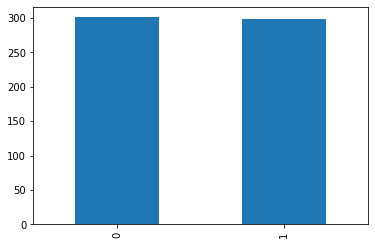

In [8]:
df['category'].value_counts().plot.bar()

In [9]:
df["category"] = df["category"].replace({0:'normal',1: 'covid'})

In [10]:
#Train test split 1/5

train_df,validate_df = train_test_split(df,test_size=0.20)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [11]:
#Image Augmentation: Saturation, random Crop, brightness, Contrast.

def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            #batch_crops[i] = tf.image.resize(batch_crops[i], [548,548])
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
            batch_crops[i] = tf.image.rgb_to_grayscale(batch_crops[i])
            #batch_crops[i] = tf.image.random_hue(batch_crops[i], 0.08)
            batch_crops[i] = tf.image.random_saturation(batch_crops[i], 0.6, 1.6)
            batch_crops[i] = tf.image.random_brightness(batch_crops[i], 0.05)
            batch_crops[i] = tf.image.random_contrast(batch_crops[i], 0.7, 1.3)
            batch_crops[i] = tf.image.random_flip_left_right(batch_crops[i], seed=None)
            batch_crops[i] = tf.image.resize(batch_crops[i], [224,224])
        yield (batch_crops, batch_y)
        
        



In [12]:
#Train Data generator

train_datagen = ImageDataGenerator(   
    rescale=1./255,
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    Data_dir_train, 
    x_col='filename',
    y_col='category',
    target_size=(256,256),
    class_mode='categorical',
    batch_size=batch_size
)


train_crops = crop_generator(train_generator, 224) #Applying Image Augmentation


#print(train_crops)

Found 479 validated image filenames belonging to 2 classes.


Found 1 validated image filenames belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<function matplotlib.pyplot.show(*args, **kw)>

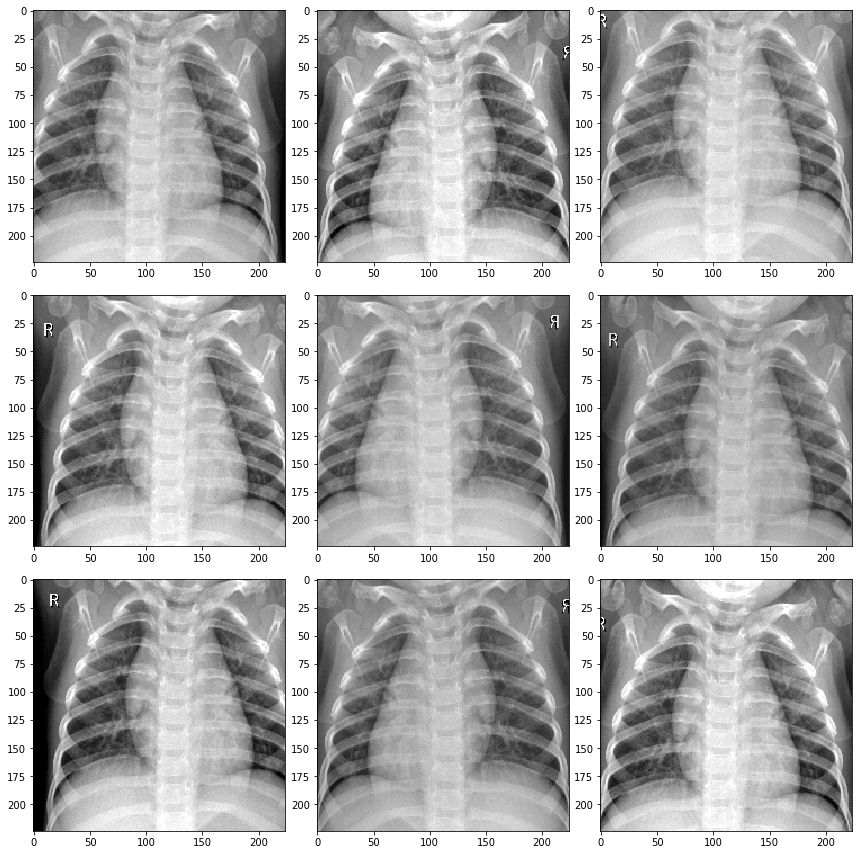

In [13]:
#Visualize Data Augmentation

example_df=train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    Data_dir_train, 
    x_col='filename',
    y_col='category',
    target_size=(256,256),
    class_mode='categorical',
    batch_size=batch_size
)
    
example_crops = crop_generator(example_generator, 224)

plt.figure(figsize=(12,12))
for i in range(0,9):
    plt.subplot(3,3,i+1)
    for X_batch,Y_batch in example_crops:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show

In [14]:
#Validation Generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(validate_df, Data_dir_train, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=batch_size)

Found 120 validated image filenames belonging to 2 classes.


In [15]:
validate_df

,filename,category
0,Normal.75.jpg,normal
1,Normal.131.jpg,normal
2,Normal.105.jpg,normal
3,Normal.528.jpg,normal
4,Normal.91.jpg,normal
...,...,...
115,Covid.83.jpg,covid
116,Normal.31.jpg,normal
117,Covid.203.jpg,covid
118,Covid.39.jpg,covid


In [16]:

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5,min_lr=0.00001)

callbacks = [earlystop,learning_rate_reduction]

In [17]:

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]



In [18]:
#Plottig History

def plot_model_history(model_history, acc='accuracy',val_acc='val_acc'):
    #fig,axs = plt.subplots(1,2,figsize = (15,5))
    plt.plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'],color='black')
    plt.plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'],color='red')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    #axs[0].set_xticks(np.arrange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    plt. legend(['train','val'],loc='best')
    plt.show()
    plt.plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'],color='black')
    plt.plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'],color='red')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    #axs[1].set_xticks(np.arrange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    plt. legend(['train','val'],loc='best')
    plt.show()
    

In [19]:
# Plotting Confusion Matrix

def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img



### Training

In [65]:


from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D,Dropout,Flatten,Dense,Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from keras.models import Model


In [66]:
#Classifer:

Prediciton0 = tf.keras.layers.GlobalMaxPooling2D()
Prediction1 = tf.keras.layers.Dense(4096,activation = 'relu')
Prediction2 = tf.keras.layers.Dense(2048,activation = 'relu')
Prediction3 = tf.keras.layers.Dense(512,activation = 'relu')
Prediction4 = tf.keras.layers.Dropout(0.5)
Prediction5 = tf.keras.layers.Dense(2,activation = 'softmax')



In [67]:
#Model: VGG 16
pre_trained_model = VGG16(input_shape = (224,224,3), include_top = False, weights='imagenet')

pre_trained_model.trainable = False

In [68]:
#BUDOWANIE SIECI __> DODANIE KLSYFIKATORA
model = tf.keras.Sequential()
model.add(pre_trained_model)
model.add(Prediciton0)
model.add(Prediction1)
model.add(Prediction2)
model.add(Prediction3)
model.add(Prediction4)
model.add(Prediction5)




In [69]:
#Loss function and optimizer
model.compile(loss='categorical_crossentropy',optimizer = 'adam',metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 4096)              2101248   
_________________________________________________________________
dense_9 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_10 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                

In [70]:
#Adding Data Augmentation to our generated Dataset
train_crops = crop_generator(train_generator, 224)

In [71]:
#Traning

epochs = 30
history = model.fit(train_crops,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps = total_validate//batch_size,
                              steps_per_epoch=total_train//batch_size,
                              callbacks=callbacks
                             )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 29 steps, validate for 7 steps
Epoch 1/30
29/29 [==============================] - 17s 578ms/step - loss: 0.9262 - accuracy: 0.7819 - recall_4: 0.7819 - precision_4: 0.7819 - val_loss: 0.0614 - val_accuracy: 0.9821 - val_recall_4: 0.9821 - val_precision_4: 0.9821
Epoch 2/30
 2/29 [=>............................] - ETA: 2s - loss: 0.1314 - accuracy: 0.9375 - recall_4: 0.9375 - precision_4: 0.9375

C:\Users\spectra\Anaconda\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,recall_4,precision_4,val_loss,val_accuracy,val_recall_4,val_precision_4,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


29/29 [==============================] - 14s 487ms/step - loss: 0.1366 - accuracy: 0.9546 - recall_4: 0.9546 - precision_4: 0.9546 - val_loss: 0.2657 - val_accuracy: 0.9107 - val_recall_4: 0.9107 - val_precision_4: 0.9107
Epoch 3/30
29/29 [==============================] - 14s 489ms/step - loss: 0.1688 - accuracy: 0.9266 - recall_4: 0.9266 - precision_4: 0.9266 - val_loss: 0.0401 - val_accuracy: 0.9911 - val_recall_4: 0.9911 - val_precision_4: 0.9911
Epoch 4/30
29/29 [==============================] - 14s 493ms/step - loss: 0.1038 - accuracy: 0.9611 - recall_4: 0.9611 - precision_4: 0.9611 - val_loss: 0.0528 - val_accuracy: 0.9821 - val_recall_4: 0.9821 - val_precision_4: 0.9821
Epoch 5/30
29/29 [==============================] - 14s 487ms/step - loss: 0.0855 - accuracy: 0.9719 - recall_4: 0.9719 - precision_4: 0.9719 - val_loss: 0.0593 - val_accuracy: 0.9821 - val_recall_4: 0.9821 - val_precision_4: 0.9821
Epoch 6/30
29/29 [==============================] - 14s 471ms/step - loss: 0.07

### Validating - TensorFlow

In [72]:
#TensorFLow Metrics

loss,accuracy,recall,precision = model.evaluate_generator(validation_generator, total_validate//batch_size,workers = 12)
print("Test accuracy:{:.3f}% ".format(accuracy))
print("Test recall:{:,.3f}% ".format(recall))
print("Test precision:{:,.3f}% ".format(precision))
print("Test loss:{:,.3f}% ".format(loss))
#print(loss)

  ...
    to  
  ['...']
Test accuracy:0.991% 
Test recall:0.991% 
Test precision:0.991% 
Test loss:0.073% 


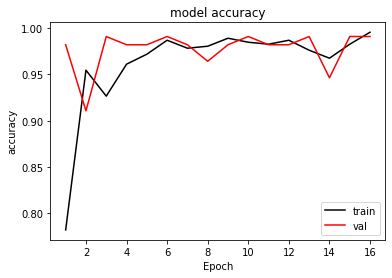

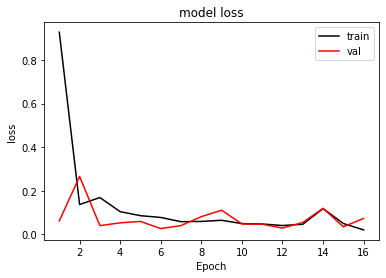

In [73]:
## Plotting Loss and Accuracy

plot_model_history(history)    

In [74]:
#####Save Model

model.save(saving_path)

In [75]:
#Load previously saved model (not necessery)
loading_path = saving_path
new_model = tf.keras.models.load_model(loading_path)
#model = new_model

### Validating -- sklearn

In [76]:
#second validation generator

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
validate_df,Data_dir_train,
x_col='filename',
y_col='category',
batch_size=batch_size,
class_mode='categorical',
target_size=(224,224),shuffle = False)

Found 120 validated image filenames belonging to 2 classes.


In [77]:
validate_df2 = validate_df.copy()
validate_df2['category2'] = None
validate_df2

,filename,category,category2
0,Normal.75.jpg,normal,None
1,Normal.131.jpg,normal,None
2,Normal.105.jpg,normal,None
3,Normal.528.jpg,normal,None
4,Normal.91.jpg,normal,None
...,...,...,...
115,Covid.83.jpg,covid,None
116,Normal.31.jpg,normal,None
117,Covid.203.jpg,covid,None
118,Covid.39.jpg,covid,None


In [78]:
#Predicting labels - output is softmax probability

predict = model.predict(test_generator, steps= np.ceil(validate_df2.shape[0]/batch_size))


In [79]:
#Predict pairs visualization - firt column is Covid probability, second is normal
len(predict)

120

In [80]:
# Changing predicitions to binary classes with threshold


threshold = 0.5
validate_df2['category2'] = np.where(predict[:,0]>threshold,1,0)
preds = np.asarray(validate_df2['category2'])
trues = np.asarray(validate_df2['category'])
preds

array([1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1])

In [81]:
#rue labels
trues

array(['normal', 'normal', 'normal', 'normal', 'normal', 'covid', 'covid',
       'normal', 'normal', 'covid', 'normal', 'normal', 'covid', 'normal',
       'covid', 'normal', 'covid', 'normal', 'normal', 'covid', 'normal',
       'normal', 'normal', 'normal', 'covid', 'covid', 'covid', 'covid',
       'normal', 'normal', 'covid', 'covid', 'normal', 'covid', 'covid',
       'covid', 'covid', 'covid', 'normal', 'normal', 'normal', 'normal',
       'covid', 'normal', 'covid', 'normal', 'covid', 'covid', 'normal',
       'normal', 'covid', 'covid', 'normal', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'normal', 'normal',
       'covid', 'normal', 'covid', 'covid', 'covid', 'normal', 'covid',
       'normal', 'normal', 'normal', 'normal', 'normal', 'covid',
       'normal', 'normal', 'covid', 'normal', 'normal', 'covid', 'normal',
       'normal', 'covid', 'covid', 'normal', 'covid', 'normal', 'covid',
       'covid', 'normal', 'normal', 'normal', 'covid'

In [82]:
# Changing output to binary classes

trues[trues == 'normal'] = 0
trues[trues == 'covid'] = 1

y_truest = np.tile(3,87)
for i in range(87):
    y_truest[i] = trues[i]    
print(y_truest)
y_finalest = np.tile(3,87)
for i in range(87):
    y_finalest[i] = preds[i]
print(y_finalest)

[0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 1 1 1 1
 1 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0 0 0
 0 1 0 0 1 0 0 1 0 0 1 1 0]
[1 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 1 1 1 1
 1 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0 0 0
 0 1 0 0 1 0 0 1 0 0 1 1 0]


In [83]:
#Sklearn Metrics --> more valid

import sklearn.metrics as metrics

print("Test accuracy:{:.3f}% ".format(metrics.accuracy_score(y_truest,y_finalest)))
print("Test recall:{:,.3f}% ".format(metrics.recall_score(y_truest,y_finalest, average='binary')))
print("Test precision:{:,.3f}% ".format(metrics.precision_score(y_truest,y_finalest, average='binary')))
print("Test F1:{:,.3f}% ".format(metrics.f1_score(y_truest,y_finalest, average='binary')))
print()

Test accuracy:0.989% 
Test recall:1.000% 
Test precision:0.977% 
Test F1:0.988% 



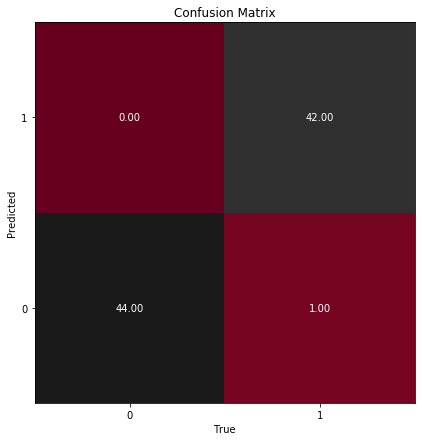

In [84]:
#Confusion Matrix in form of heatmap

import sklearn.metrics as metrics


personality_types = np.unique(y_truest)
plt.figure(figsize = (7,7))
plt.title("Confusion Matrix")
heatmap(metrics.confusion_matrix(y_truest,y_finalest), xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="RdGy")
plt.show()

### Test

In [85]:
#Single Image Class prediction
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
single_image_path1 = r'C:\Users\spectra\Downloads\covid-chest-xray\images\Covid.1.jpg'
single_image_path2 = r'C:\Users\spectra\Downloads\covid-chest-xray\images\Normal.501.jpg'
single_image_path_softmax = test_path

img = image.load_img(single_image_path1, target_size=(224, 224))
x = image.img_to_array(img)

x = np.expand_dims(x, axis=0)

classes = model.predict(x, steps= np.ceil(1), batch_size=1)

print (classes)


[[1. 0.]]


In [86]:
#Predicting sigle image softmax probability

from keras.models import load_model
from keras.preprocessing import image
import numpy as np
test_filename = 'Normal.504.jpg'

test_df = pd.DataFrame({
    'filename': [test_filename],
    'category': [None]
})

test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
test_df,single_image_path_softmax,
x_col='filename',
y_col=None,
batch_size=1,
    class_mode=None,
target_size=(224,224))

classes = model.predict(test_generator)


print (classes)


Found 1 validated image filenames.
[[8.1384474e-05 9.9991858e-01]]


In [87]:
#Flowing Images Names from directory to dataframe

test_filenames = os.listdir(test_path)
test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': None
})
nb_samples = test_df.shape[0]
print(test_df)

           filename category
0       Covid.0.jpg     None
1       Covid.1.jpg     None
2      Covid.10.jpg     None
3     Covid.100.jpg     None
4     Covid.101.jpg     None
..              ...      ...
278  Normal.626.jpg     None
279  Normal.633.jpg     None
280  Normal.634.jpg     None
281  Normal.635.jpg     None
282  Normal.636.jpg     None

[283 rows x 2 columns]


In [88]:
#Creating no- class test generator

batch_size = 16

test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
test_df,test_path,
x_col='filename',
y_col=None,
batch_size=batch_size,
    class_mode=None,
target_size=(224,224),shuffle = False)

Found 283 validated image filenames.


In [89]:
#PRedicting generator

predict = model.predict_generator(test_generator, steps= np.ceil(nb_samples/batch_size))


Instructions for updating:
Please use Model.predict, which supports generators.


In [90]:
#Showung predicts content
predict

array([[1.00000000e+00, 2.41199394e-10],
       [9.99994755e-01, 5.23711924e-06],
       [9.99999642e-01, 3.71923619e-07],
       [1.00000000e+00, 7.45152207e-09],
       [1.00000000e+00, 1.94021790e-14],
       [1.00000000e+00, 1.96692120e-12],
       [1.00000000e+00, 1.08859987e-11],
       [1.00000000e+00, 1.75731679e-10],
       [9.99999762e-01, 2.08676454e-07],
       [9.99997258e-01, 2.76692958e-06],
       [9.99999881e-01, 1.56590744e-07],
       [9.99964118e-01, 3.58741236e-05],
       [1.00000000e+00, 2.73644507e-09],
       [1.00000000e+00, 1.69527758e-09],
       [1.00000000e+00, 1.69872880e-08],
       [1.00000000e+00, 2.10080314e-10],
       [1.00000000e+00, 8.21844871e-13],
       [1.00000000e+00, 1.38698508e-09],
       [1.00000000e+00, 5.20155687e-08],
       [1.00000000e+00, 1.45728996e-09],
       [1.00000000e+00, 2.20560202e-11],
       [1.00000000e+00, 9.06375863e-09],
       [1.00000000e+00, 3.07934789e-11],
       [1.00000000e+00, 3.97664297e-11],
       [9.999606

In [91]:
#Applying labels according to threshold

threshold = 0.5
test_df['category'] = np.where(predict[:,0]>threshold,'covid','normal')


In [92]:
with pd.option_context("display.max_rows", 1000):
    display(test_df)

,filename,category
0,Covid.0.jpg,covid
1,Covid.1.jpg,covid
2,Covid.10.jpg,covid
3,Covid.100.jpg,covid
4,Covid.101.jpg,covid
5,Covid.102.jpg,covid
6,Covid.103.jpg,covid
7,Covid.104.jpg,covid
8,Covid.105.jpg,covid
9,Covid.106.jpg,covid


<Figure size 864x864 with 0 Axes>

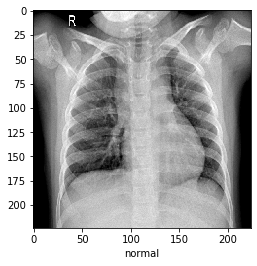

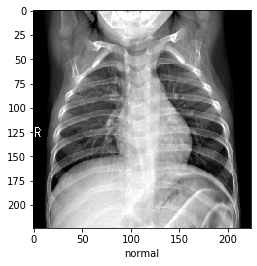

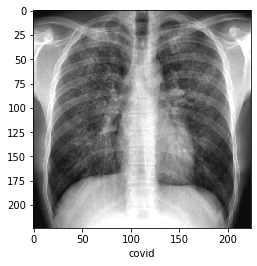

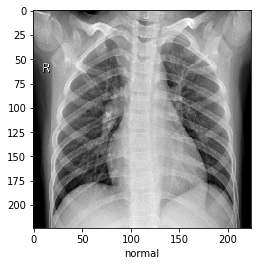

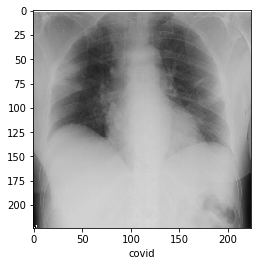

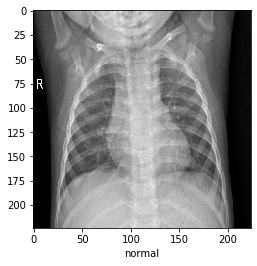

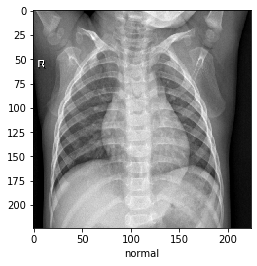

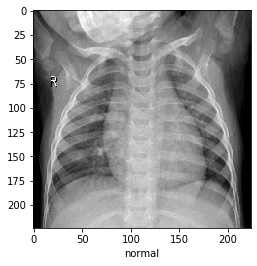

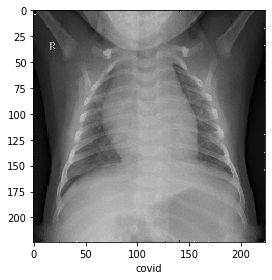

In [93]:
#Image Showing nad labeling

sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12,12))
for index,row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(test_path+"\\"+filename,target_size=(224,224))
    plt.subplots(1,1)
    plt.imshow(img)
    plt.xlabel( "{}".format(category))
plt.tight_layout()
plt.show()